### PROJETO 1 REDES SOCIAIS

**GRUPO D:** 
- ESTHER DAGIR
- FELIPE LEMOS
- JV PAZOTTI

**DESCRIÇÃO DATASET CORD19**

Artigos acadêmicos relacionados ao COVID-19 e suas variantes que integram o dataset CORD-19. Coleção mais extensa (+134.000 artigos) de pesquisa sobre coronavírus legível por máquina disponível para mineração de dados até o momento, solicitada pelo governo americano em conjunto com entidades de pesquisa sobre o vírus e suas variantes. 

### Importando as Bibliotecas


In [2]:
import pandas as pd
import seaborn as sns
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *

### Dataset

In [131]:
raw_data = pd.read_csv("metadata.csv")

/tmp/ipykernel_88/4156001419.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("metadata.csv")


In [132]:
data = raw_data 

In [133]:
unique_journals = data['journal'].unique().tolist()
len(unique_journals)

54994

In [134]:
unique_journals

['BMC Infect Dis',
 'Respir Res',
 'The EMBO Journal',
 'Crit Care',
 'Journal of the American Medical Informatics Association',
 'EMBO J',
 'Biol Proced Online',
 'J Transl Med',
 'Retrovirology',
 'BMC Public Health',
 'BMC Genomics',
 'Aust New Zealand Health Policy',
 'Microb Cell Fact',
 'Nucleic Acids Res',
 'J Biomed Biotechnol',
 'BMC Gastroenterol',
 'PLoS Biol',
 'Int J Health Geogr',
 'Global Health',
 'Virol J',
 'Immunome Res',
 'BMC Mol Biol',
 'PLoS Med',
 'BMC Biotechnol',
 'Harm Reduct J',
 'Nat Med',
 'BMC Med Ethics',
 'Evid Based Complement Alternat Med',
 'J Gen Intern Med',
 'PLoS Comput Biol',
 'Ann Clin Microbiol Antimicrob',
 'Methods',
 'Reprod Biol Endocrinol',
 'Theor Biol Med Model',
 'Clinical Chemistry',
 'BMC Bioinformatics',
 'Journal of Neuropathology and Experimental Neurology',
 'PLoS One',
 'PLoS Pathog',
 'Mediators Inflamm',
 'Genome Biol',
 'Insect Mol Biol',
 'Cell Microbiol',
 'AIDS Res Ther',
 'Emerg Infect Dis',
 'Cytokine & Growth Factor Rev

In [ ]:
data

In [ ]:
data.info()

In [135]:
data=data.copy().drop(columns=['pdf_json_files','pmc_json_files','arxiv_id','pmcid',
                               'mag_id','s2_id','sha','cord_uid','abstract','url','mag_id','publish_time',
                                  'source_x','license','who_covidence_id','pubmed_id'])
data=data.dropna()

In [136]:
data['authors'] = data['authors'].astype(str)

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595159 entries, 0 to 1056659
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   title    595159 non-null  object
 1   doi      595159 non-null  object
 2   authors  595159 non-null  object
 3   journal  595159 non-null  object
dtypes: object(4)
memory usage: 22.7+ MB


### Construindo a rede de coautoria

In [138]:
collabs = {}
coautorias = [] 

for authors in data['authors']:
    authors_list = authors.split('; ')
    # percorre todos os pares de autores na lista
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
#             print([authors_list[i],':',  authors_list[j]])
            # ordena os nomes dos autores em ordem alfabética para evitar duplicatas
            pair = tuple(sorted([authors_list[i], authors_list[j]]))
            coautorias.append(pair)          
            collabs[pair] = collabs.get(pair, 0) + 1  
#         print('saiu autor')

In [139]:
coautorias_unicas = []
coautorias_set = set()

for coautoria in coautorias:
    coautoria_ordenada = tuple(sorted(coautoria))
    if coautoria_ordenada not in coautorias_set:
        coautorias_unicas.append(coautoria)
        coautorias_set.add(coautoria_ordenada)

In [140]:
coautorias_count = {}

for coautoria in coautorias_unicas:
    autor1, autor2 = coautoria
    
    coautorias_count[autor1] = coautorias_count.get(autor1, 0) + 1
    coautorias_count[autor2] = coautorias_count.get(autor2, 0) + 1


In [141]:
coautorias_filtradas = []

for coautoria in coautorias_unicas:
    autor1, autor2 = coautoria
    
    if coautorias_count.get(autor1, 0) >= 3 and coautorias_count.get(autor1, 0) < 50 and coautorias_count.get(autor2, 0) >= 3 and coautorias_count.get(autor2, 0) <50:
        
        coautorias_filtradas.append(coautoria)

In [142]:
inf_coautorias_count = {} #contagem entre autores influentes

for coautoria in coautorias_filtradas:
    autor1, autor2 = coautoria
    
    inf_coautorias_count[autor1] = inf_coautorias_count.get(autor1, 0) + 1
    inf_coautorias_count[autor2] = inf_coautorias_count.get(autor2, 0) + 1
    

In [143]:
inf_coautorias_filtradas = []

for coautoria in coautorias_filtradas:
    autor1, autor2 = coautoria
    
    if inf_coautorias_count.get(autor1, 0) > 6 and inf_coautorias_count.get(autor2, 0) > 6:
        
        inf_coautorias_filtradas.append(coautoria)


In [ ]:
# #célula de testes 
# coautorias_unicas = [
#     ('a', 'b'), ('a', 'd'), ('a', 'f'),
#     ('f', 'i'), ('k', 'm'), ('o', 'p'),
#     ('f', 't'), ('p', 'm'), ('o', 't'),
#     ('f', 'j'), ('k', 'l'), ('a', 'p'),
#     ('f', 'p'), ('k', 'i'), ('o', 'f'),
# ]

        
# coautorias_count = {}

# for coautoria in coautorias_unicas:
#     autor1, autor2 = coautoria
    
#     coautorias_count[autor1] = coautorias_count.get(autor1, 0) + 1
#     coautorias_count[autor2] = coautorias_count.get(autor2, 0) + 1

# coautorias_filtradas = []

# for coautoria in coautorias_unicas:
#     autor1, autor2 = coautoria
    
#     if coautorias_count.get(autor1, 0) >= 3 and coautorias_count.get(autor1, 0) < 50 and coautorias_count.get(autor2, 0) >= 3 and coautorias_count.get(autor2, 0) <50:
        
#         coautorias_filtradas.append(coautoria)
        
        
# inf_coautorias_count = {}

# for coautoria in coautorias_filtradas:
#     autor1, autor2 = coautoria
    
#     inf_coautorias_count[autor1] = inf_coautorias_count.get(autor1, 0) + 1
#     inf_coautorias_count[autor2] = inf_coautorias_count.get(autor2, 0) + 1
    
# inf_coautorias_filtradas = []

# for coautoria in coautorias_filtradas:
#     autor1, autor2 = coautoria
    
#     if inf_coautorias_count.get(autor1, 0) >= 3 and inf_coautorias_count.get(autor2, 0) >= 3:
        
#         inf_coautorias_filtradas.append(coautoria)

# print(coautorias_count) #        {'a': 4, 'b': 1, 'd': 1, 'f': 6, 'i': 2, 'k': 3, 'm': 2, 'o': 3, 'p': 4, 't': 2, 'j': 1, 'l': 1}
# print(coautorias_filtradas) #    [('a', 'f'), ('o', 'p'), ('a', 'p'), ('f', 'p'), ('o', 'f')]
# print(inf_coautorias_count) #    {'a': 2, 'f': 3, 'o': 2, 'p': 3}
# print(inf_coautorias_filtradas)# [('f', 'p')]

In [145]:
import numpy as np


quantidades = list(inf_coautorias_count.values())

media = np.mean(quantidades)
mediana = np.median(quantidades)

print("Média: ", media)
print("Mediana: ", mediana)



Média:  9.492380842778852
Mediana:  7.0


In [8]:
g=gt_load('./cord19_graph.net.gz')

In [9]:
cord19 = gt_data(g)

In [10]:
n = g.num_vertices()
m =  g.num_edges()
max_edges = n * (n - 1) if g.is_directed() else n * (n - 1) // 2
d = m / max_edges

print('Número de vértices de g:', n)
print('Número de arestas de g:', m)
print('Máximo possível de arestas de g:', max_edges)
print('Densidade de g:', d)

Número de vértices de g: 9704
Número de arestas de g: 66805
Máximo possível de arestas de g: 47078956
Densidade de g: 0.001418999180865438


In [11]:
# for v in g.all_vertices():
#     if v.total_degree()==1:
#         try:
#             g.remove_vertex(v['id'])
#         except ValueError as e:
#             print("Erro ao retirar o vertice {}: {}".format(v, e))

In [12]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())

cord19['degree'] = degrees
cord19

,degree
id,
0,7
1,23
2,13
3,18
4,15
...,...
9699,10
9700,8
9701,9


In [13]:
cord19['degree'].value_counts()

8     1122
7     1099
9      930
10     795
12     604
11     576
13     442
15     413
14     382
18     377
16     296
17     284
19     228
20     183
29     132
33     128
2      122
25     120
27     120
22     119
23     116
21     112
28     108
30     104
3      103
1       93
34      75
26      63
32      63
4       61
39      47
44      47
35      45
5       42
31      26
24      26
6       25
37      18
36      14
40      14
38       9
43       7
41       5
42       4
45       4
46       1
Name: degree, dtype: int64

In [14]:
cord19.to_csv('cord19.csv')

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


count    9704.000000
mean       13.768549
std         7.913647
min         1.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        46.000000
Name: degree, dtype: float64

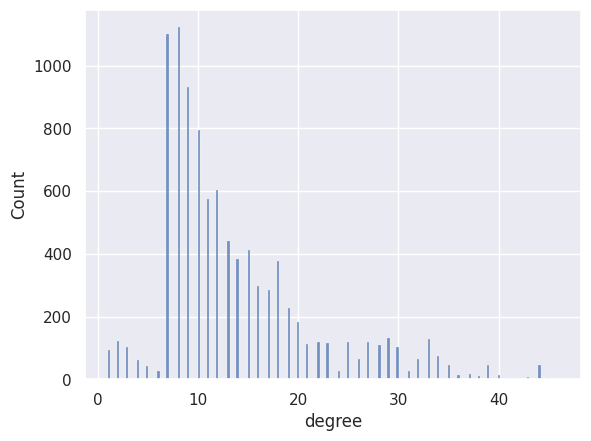

In [15]:
sns.histplot(cord19['degree'],bins=200)
cord19['degree'].describe()

In [ ]:
gt_save(g, './cord19_graph.net.gz')

In [16]:
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, './cord19_graph.net.gz')
r = netpixi.render('./cord19_graph.net.gz', infinite=True)

In [18]:
from graph_tool import centrality


In [19]:
r.vertex_default(color=0x09DB8F ,size=5)
r.edge_default(color=0xFFFFFF, width=0.5)

In [20]:
bc, _ = centrality.betweenness(g)
g.add_vp('betweenness', bc)
bt_data=gt_data(g)

In [21]:
vertex_data=pd.merge(bt_data,cord19,on='id')
vertex_data

,betweenness,degree
id,,
0,0.000000,7
1,0.000000,23
2,0.000000,13
3,0.000000,18
4,0.000000,15
...,...,...
9699,0.013996,10
9700,0.000000,8
9701,0.000000,9


In [22]:
vertex_data.describe()

,betweenness,degree
count,9704.000000,9704.000000
mean,0.001231,13.768549
std,0.013442,7.913647
min,0.000000,1.000000
25%,0.000000,8.000000
50%,0.000000,11.000000
75%,0.000000,17.000000
max,0.493054,46.000000


In [23]:
import regression as reg
import numpy as np

In [24]:
journal_data=pd.read_csv('df_final.csv')
journal_data

,doi,title,authors,journal,Rank,SJR,h_index,total_docs,total_refs,total_cits,avg_cit_per_doc,avg_ref_per_doc,Country,Region,Publisher,Coverage,Categories,Areas
0,10.1186/1471-2458-4-34,Logistics of community smallpox control throug...,"Porco, Travis C; Holbrook, Karen A; Fernyak, S...",bmc public health,2695,"1,307",178,8305,115725,28137,"4,49","48,24",United Kingdom,Western Europe,BioMed Central Ltd.,2001-2022,"Public Health, Environmental and Occupational ...",Medicine
1,NaN,Reduced level of physical activity during COVI...,"Puccinelli, P. J.; da Costa, T. S.; Seffrin, A...",bmc public health,2695,"1,307",178,8305,115725,28137,"4,49","48,24",United Kingdom,Western Europe,BioMed Central Ltd.,2001-2022,"Public Health, Environmental and Occupational ...",Medicine
2,10.1186/1475-2859-4-2,Protein secretion in Lactococcus lactis : an e...,"Le Loir, Yves; Azevedo, Vasco; Oliveira, Sergi...",microbial cell factories,3647,"1,091",116,937,15174,4401,"6,45","54,98",United Kingdom,Western Europe,BioMed Central Ltd.,2002-2022,Applied Microbiology and Biotechnology (Q1); B...,"Biochemistry, Genetics and Molecular Biology; ..."
3,10.1186/s12934-020-01429-7,Correction to: Activation and enhancement of c...,"Xie, Yunchang; Chen, Jiawen; Wang, Bo; Chen, T...",microbial cell factories,3647,"1,091",116,937,15174,4401,"6,45","54,98",United Kingdom,Western Europe,BioMed Central Ltd.,2002-2022,Applied Microbiology and Biotechnology (Q1); B...,"Biochemistry, Genetics and Molecular Biology; ..."
4,10.15698/mic2022.01.767,Detection of severe acute respiratory syndrome...,"Durand, Mathieu; Thibault, Philippe; Lévesque,...",microbial cell factories,3647,"1,091",116,937,15174,4401,"6,45","54,98",United Kingdom,Western Europe,BioMed Central Ltd.,2002-2022,Applied Microbiology and Biotechnology (Q1); B...,"Biochemistry, Genetics and Molecular Biology; ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5090,10.1109/jsac.2021.3088663,5G-Enabled UAV-to-Community Offloading: Joint ...,"Ning, Z. L.; Dong, P. R.; Wen, M. W.; Wang, X....",ieee journal on selected areas in communications,122,"7,656",251,927,11676,11104,"16,98","48,25",United States,Northern America,Institute of Electrical and Electronics Engine...,1983-2022,Computer Networks and Communications (Q1); Ele...,Computer Science; Engineering
5091,10.3233/cbm-203103,YTHDF1 amplification is correlated with worse ...,"Li, Cheukfai; Zhang, Chuanzhao; Zhang, Guochun...",cancer biomarkers,8223,"0,622",50,562,5612,1297,"2,86","40,96",Netherlands,Western Europe,IOS Press BV,2005-2022,Medicine (miscellaneous) (Q2); Cancer Research...,"Biochemistry, Genetics and Molecular Biology; ..."
5092,10.1097/mou.0000000000000973,Implications and effects of COVID-19 on diagno...,"Chan, V. W.; Asif, A.; Koe, J. S.; Ng, A.; Ng,...",current opinion in neurology,1722,"1,701",130,455,6759,1859,"4,54","60,35",United States,Northern America,Lippincott Williams and Wilkins Ltd.,1993-2022,Neurology (Q1); Neurology (clinical) (Q1),Medicine; Neuroscience
5093,10.1016/j.camwa.2022.01.013,Numerical simulation of pulmonary airway reope...,"He, B.; Qin, C.; Chen, W.; Wen, B.",computers and mathematics with applications,5382,"0,857",143,1590,15796,3779,"2,99","42,81",United Kingdom,Western Europe,Elsevier Ltd.,1975-2022,Computational Theory and Mathematics (Q1); Mod...,Computer Science; Mathematics


In [25]:
journal_data['SJR'] = journal_data['SJR'].str.replace(',', '.').astype(float)

In [26]:
# Fazendo uma cópia do dataframe
journal_copy = journal_data.copy()

# Transformando a string de autores em uma lista
journal_copy['authors'] = journal_copy['authors'].apply(lambda x: x.split('; '))

# Usando explode para que cada autor tenha sua própria linha
journal_copy = journal_copy.explode('authors')

journal_copy = journal_copy.drop_duplicates(subset='authors', keep='first')


In [27]:


# Classifique data_copy pelo valor da coluna 'Rank' e redefina o índice.
journal_copy = journal_copy.sort_values('Rank').reset_index(drop=True)

# Reduza data_copy para ter o mesmo número de linhas que vertex_data.
journal_copy = journal_copy.iloc[:len(vertex_data)]


In [28]:
journal_copy.reset_index(inplace=True)

journal_copy.rename(columns={'index': 'id'}, inplace=True)

journal_copy




,id,doi,title,authors,journal,Rank,SJR,h_index,total_docs,total_refs,total_cits,avg_cit_per_doc,avg_ref_per_doc,Country,Region,Publisher,Coverage,Categories,Areas
0,0,10.1038/ncb3580,Local lung hypoxia determines epithelial fate ...,"Shannon, John M.",nature reviews molecular cell biology,3,34.201,485,449,10804,13331,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
1,1,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Tisné, Carine",nature reviews molecular cell biology,3,34.201,485,449,10804,13331,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
2,2,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Luisi, Ben F",nature reviews molecular cell biology,3,34.201,485,449,10804,13331,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
3,3,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Cianferani, Sarah",nature reviews molecular cell biology,3,34.201,485,449,10804,13331,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
4,4,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Barraud, Pierre",nature reviews molecular cell biology,3,34.201,485,449,10804,13331,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9699,9699,10.14336/ad.2021.1102,Rapidly Progressive Dementia with Asymmetric R...,"Jaiswal, S.",aging and disease,1751,1.682,72,517,13927,2973,"7,25","107,96",United States,Northern America,International Society on Aging and Disease,2010-2022,Cell Biology (Q1); Geriatrics and Gerontology ...,"Biochemistry, Genetics and Molecular Biology; ..."
9700,9700,10.14336/ad.2021.1102,Rapidly Progressive Dementia with Asymmetric R...,"Chakrabarti, S. S.",aging and disease,1751,1.682,72,517,13927,2973,"7,25","107,96",United States,Northern America,International Society on Aging and Disease,2010-2022,Cell Biology (Q1); Geriatrics and Gerontology ...,"Biochemistry, Genetics and Molecular Biology; ..."
9701,9701,10.14336/ad.2021.1102,Rapidly Progressive Dementia with Asymmetric R...,"Kumar, I.",aging and disease,1751,1.682,72,517,13927,2973,"7,25","107,96",United States,Northern America,International Society on Aging and Disease,2010-2022,Cell Biology (Q1); Geriatrics and Gerontology ...,"Biochemistry, Genetics and Molecular Biology; ..."
9702,9702,10.1111/cpr.13042,Maternal sevoflurane exposure induces temporar...,"Tang, Tianxiang",cell proliferation,1752,1.681,85,709,10090,4441,"8,24","59,01",United Kingdom,Western Europe,Wiley-Blackwell Publishing Ltd,"1968-1982, 1984-2022",Cell Biology (Q1); Medicine (miscellaneous) (Q1),"Biochemistry, Genetics and Molecular Biology; ..."


In [36]:
vertex_copy=vertex_data.copy()
reg_data=pd.merge(journal_copy,vertex_copy,on='id')
reg_data['avg_cit_per_doc'] = reg_data['avg_cit_per_doc'].str.replace(',', '.').astype(float)

reg_data

,id,doi,title,authors,journal,Rank,SJR,h_index,total_docs,total_refs,...,avg_cit_per_doc,avg_ref_per_doc,Country,Region,Publisher,Coverage,Categories,Areas,betweenness,degree
0,0,10.1038/ncb3580,Local lung hypoxia determines epithelial fate ...,"Shannon, John M.",nature reviews molecular cell biology,3,34.201,485,449,10804,...,35.47,"89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology",0.000000,7
1,1,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Tisné, Carine",nature reviews molecular cell biology,3,34.201,485,449,10804,...,35.47,"89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology",0.000000,23
2,2,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Luisi, Ben F",nature reviews molecular cell biology,3,34.201,485,449,10804,...,35.47,"89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology",0.000000,13
3,3,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Cianferani, Sarah",nature reviews molecular cell biology,3,34.201,485,449,10804,...,35.47,"89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology",0.000000,18
4,4,10.1016/j.molcel.2020.09.008,Structures of B. subtilis Maturation RNases Ca...,"Barraud, Pierre",nature reviews molecular cell biology,3,34.201,485,449,10804,...,35.47,"89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology",0.000000,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9699,9699,10.14336/ad.2021.1102,Rapidly Progressive Dementia with Asymmetric R...,"Jaiswal, S.",aging and disease,1751,1.682,72,517,13927,...,7.25,"107,96",United States,Northern America,International Society on Aging and Disease,2010-2022,Cell Biology (Q1); Geriatrics and Gerontology ...,"Biochemistry, Genetics and Molecular Biology; ...",0.013996,10
9700,9700,10.14336/ad.2021.1102,Rapidly Progressive Dementia with Asymmetric R...,"Chakrabarti, S. S.",aging and disease,1751,1.682,72,517,13927,...,7.25,"107,96",United States,Northern America,International Society on Aging and Disease,2010-2022,Cell Biology (Q1); Geriatrics and Gerontology ...,"Biochemistry, Genetics and Molecular Biology; ...",0.000000,8
9701,9701,10.14336/ad.2021.1102,Rapidly Progressive Dementia with Asymmetric R...,"Kumar, I.",aging and disease,1751,1.682,72,517,13927,...,7.25,"107,96",United States,Northern America,International Society on Aging and Disease,2010-2022,Cell Biology (Q1); Geriatrics and Gerontology ...,"Biochemistry, Genetics and Molecular Biology; ...",0.000000,9
9702,9702,10.1111/cpr.13042,Maternal sevoflurane exposure induces temporar...,"Tang, Tianxiang",cell proliferation,1752,1.681,85,709,10090,...,8.24,"59,01",United Kingdom,Western Europe,Wiley-Blackwell Publishing Ltd,"1968-1982, 1984-2022",Cell Biology (Q1); Medicine (miscellaneous) (Q1),"Biochemistry, Genetics and Molecular Biology; ...",0.000000,11


In [41]:
import regression as reg
result = reg.linear(data=reg_data, formula='degree ~  + Rank + total_docs + total_refs+ total_cits + SJR + h_index ')
result.micro_summary()

variable,coefficient,std error,p-value
Rank,-0.000163,0.000191,0.393703
total_docs,0.000189,0.000102,0.062572
total_refs,-0.000007,0.000004,0.095638
total_cits,-0.000004,0.000008,0.659934
SJR,0.010005,0.027184,0.712846
h_index,-0.000575,0.000757,0.447209


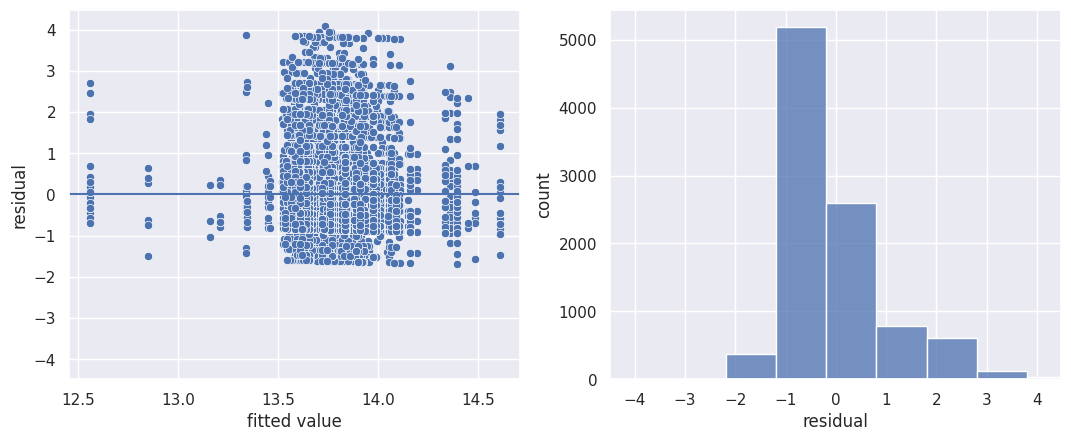

In [33]:
result.plot_residuals()

In [34]:
result = reg.linear(data=reg_data, formula='degree ~ betweenness + Rank + total_docs + total_refs+ total_cits + SJR + h_index')
result.micro_summary()

variable,coefficient,std error,p-value
betweenness,51.848469,5.955024,0.000000
Rank,-0.000143,0.000190,0.452540
total_docs,0.000188,0.000101,0.064024
total_refs,-0.000007,0.000004,0.088023
total_cits,-0.000003,0.000008,0.702887
SJR,0.010784,0.027080,0.690462
h_index,-0.000555,0.000754,0.461470


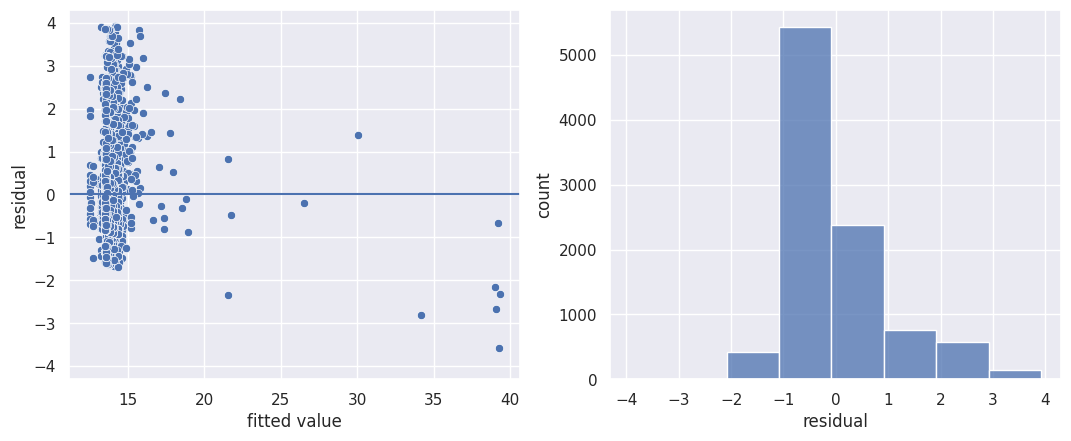

In [35]:
result.plot_residuals()